In [61]:
#Indian houses price prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import re

df = pd.read_csv('House_Rent_Dataset.csv')

In [62]:
def FloorsArray():
    checked = []
    final_values = []
    for i in range(len(df['Floor'])):
        original_string = df['Floor'][i]
        result_string = re.sub(r'\d+', '', original_string)
        if (result_string not in checked):
            final_values.append(result_string)
            checked.append(result_string)
    value_arr = [0 if final_values[0] in line or final_values[-1] in line else int(line[-1]) + 1 if final_values[2] in line else int(line[-1]) - 1 if final_values[3] in line else int(line.split()[0]) if final_values[1] in line else int(line[0]) for line in df['Floor']]
    df['Floor'] = value_arr

FloorsArray()

def Categorical_Quantitative_arr(file):
    column_arr = file.columns.unique()
    categorical = []
    quantitative = []
    for i in range(len(column_arr)):
        try: float(file[column_arr[i]][0])
        except:
            categorical.append(('categorical', f"{column_arr[i]}"))
            continue
        quantitative.append(('quantitative', f"{column_arr[i]}"))
    return (categorical, quantitative)
    
(categorical, quantitative) = Categorical_Quantitative_arr(df)

def PrintingCorrelationMatrix(file, categorical):
    columns = []
    for i in range(len(categorical)):
        columns.append(categorical[i][1])
    new_table = file.drop(columns=columns, axis=1)
    values = new_table.corr()
    return (values.to_numpy(), new_table.columns)

def Finiding_possible_mistakes(figure, file_column, file, multiplier):
    column = file_column
    file_column = file[file_column]

    std = np.std(file_column)
    threshold = multiplier * std
    mean_value = file_column.mean()

    possible_errors = file_column[(file_column-mean_value).abs() > threshold]
    error_index = possible_errors.index.to_numpy()

    color_arr = ['red' if i in error_index else 'royalblue' for i in range(len(file[column]))]
    function_object = np.poly1d(np.polyfit(file['Size'], (file_column-mean_value).abs(), deg=1))
    figure.plot(file['Size'], function_object(file['Size']), c='yellow', linewidth=3, linestyle='dashed', label='Best fit line for training data')
    figure.scatter(file['Size'], (file_column-mean_value).abs(), c=color_arr, s=50, alpha=0.8)

    if threshold < file_column[file_column.idxmax()]: figure.axhline(threshold, c='red', label=f'Std (Standart deviation) threshold: {(threshold+mean_value):.2f}')
    else: figure.axhline(0, c='red', label=f"Std (Standart deviation) threshold: {(threshold+mean_value):.2f} (no mistakes)")

    figure.ticklabel_format(axis='y', style='plain')
    figure.legend(loc=1, fontsize=8, prop={'weight': 'bold'})
    no_error_file = file.drop(error_index, axis=0)
    return (color_arr.count('red'), no_error_file)

def Getting_correlations(fig_1, correlation_labels, correlation_arr):
    for i in range(len(correlation_labels)):
        for j in range(len(correlation_labels)):
            text = f'{correlation_arr[i, j]:.2f}'
            fig_1.text(j, i, text, ha='center', va='center', color='k', fontsize=10, weight='bold')

def Printing_legend(figure, area_arr, price_arr, color_arr, contact_arr_labels, zorder_arr):
    unique_colors = pd.Series(color_arr).unique()
    unique_contact = pd.Series(contact_arr_labels).unique()
    i = 0
    for c in unique_colors:
        mask = (color_arr == c)
        figure.scatter(area_arr[mask], price_arr[mask], c=c, label=unique_contact[i], s=20, zorder=zorder_arr[mask].mean())
        i+=1
    figure.legend(loc=1, fontsize=9)

def Printing_upper_top3(arrayToPlot, starting_position_array, color_arr, lastFigureID, title_arr):
    for i in range(len(arrayToPlot)):
        figureID = f"fig_{int(lastFigureID.split('_')[-1])+1+i}"
        try:
            figureID = plt.subplot2grid((8, 12), starting_position_array[i], rowspan=2, colspan=3)
            bins, a, _ = figureID.hist(arrayToPlot[i], bins=len(arrayToPlot[i].unique()), ec="white", color=color_arr[i], alpha=0.85)
            figureID.set_title(title_arr[i],  weight='bold', fontsize=11)
            figureID.set_ylim(0, max(np.array(bins)) + np.array(bins).mean())
            value = float(arrayToPlot[i][0])
            continue
        except:
            figureID.set_xticks(range(len(arrayToPlot[i].unique())))
            figureID.set_xticklabels(arrayToPlot[i].unique(), rotation=30, fontsize=7, weight='bold')

def GettingPersonInput():
    thresholdSTD = ""
    while(True):
        thresholdSTD = input("Input a threshold of Standart deviation: ")
        try: 
            thresholdSTD = int(thresholdSTD)
            if(thresholdSTD > 0): break
        except: 
            print("Error!\n1)Input value is not integer\n2)Input value is negative")
            continue
    return thresholdSTD

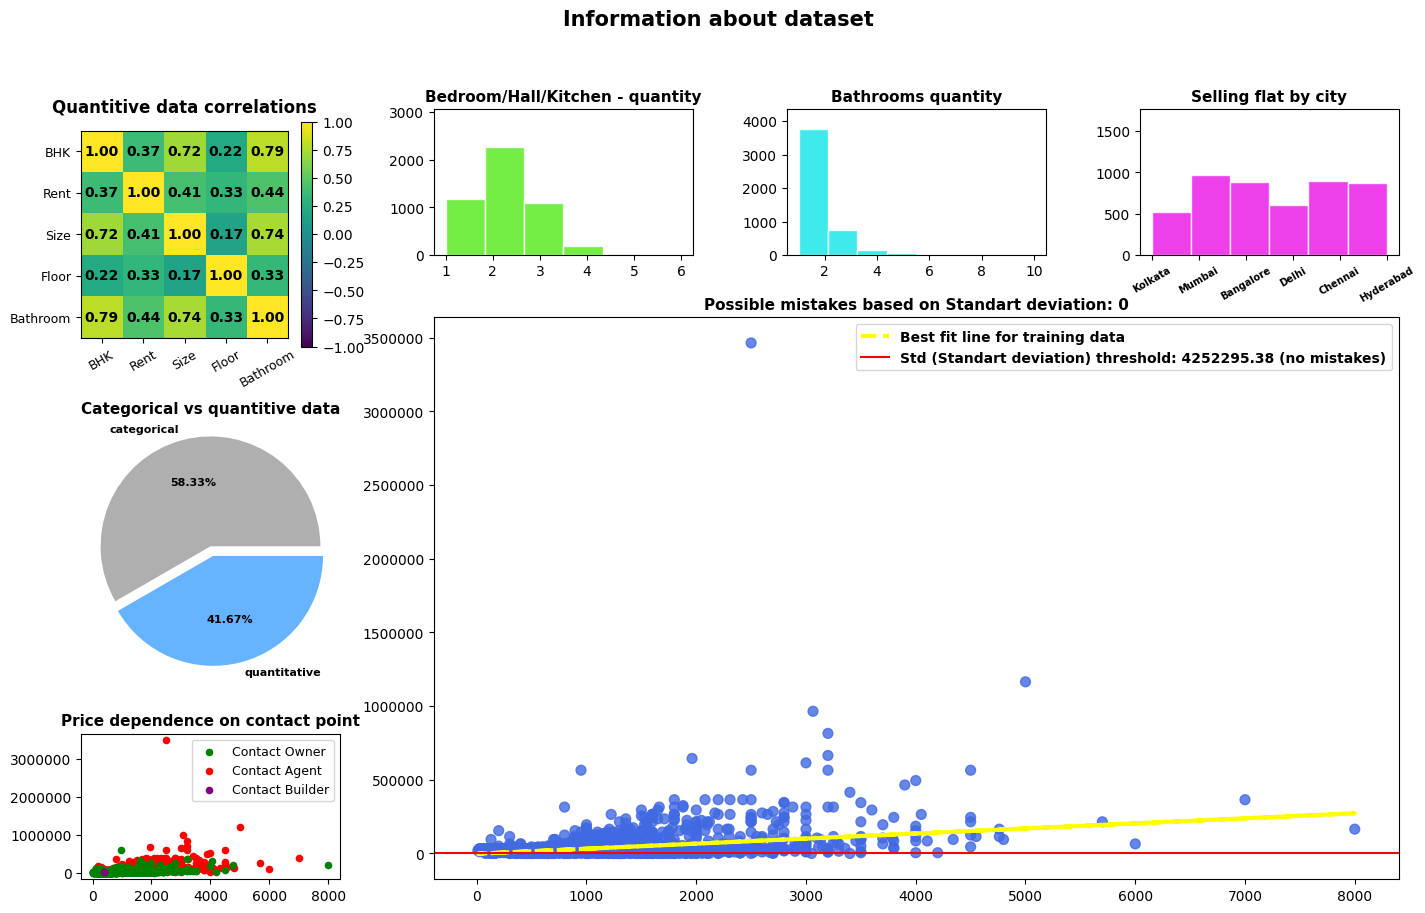

In [63]:
#Information about dataset
fig = plt.figure(figsize=(17, 10))
fig.suptitle("Information about dataset", weight='bold', fontsize=15)

def Change_ax_style():
    return plt.ticklabel_format(axis='y', style='plain')

def Add_labels(figure, title):
    figure.set_title(title, weight='bold', fontsize=11)

price_column = df['Rent']
area_column = df['Size']
rooms_arr = df['BHK']
cities_arr = df['City']
bath_arr = df['Bathroom']
contact_arr = df['Point of Contact']
floor_arr = df['Floor']

fig_1 = plt.subplot2grid((8, 12), (0, 0), rowspan=3, colspan=3)
(correlation_arr, correlation_labels) = PrintingCorrelationMatrix(df, categorical)
cax = fig_1.imshow(correlation_arr, cmap='viridis', vmin=-1, vmax=1)
Getting_correlations(fig_1, correlation_labels, correlation_arr)
fig_1.set_xticks(np.arange(len(correlation_labels)))
fig_1.set_yticks(np.arange(len(correlation_labels)))
fig_1.set_xticklabels(correlation_labels, rotation=30, fontsize=9)
fig_1.set_yticklabels(correlation_labels, fontsize=9)
fig_1.set_title('Quantitive data correlations', y=1.05, weight='bold')

colors = ['#AFAFAF', '#66b3ff']
fig_2 = plt.subplot2grid((8, 12), (3, 0), rowspan=3, colspan=3)
fig_2.pie([f"{len(categorical)}", f"{len(quantitative)}"],
            radius=1.1, explode=[0, 0.1], labels=['categorical', 'quantitative'],
            autopct='%1.2f%%', textprops={'fontsize': 8, 'weight': 'bold'}, colors=colors)
fig_2.set_title('Categorical vs quantitive data', )
Add_labels(fig_2, 'Categorical vs quantitive data')

fig_3 = plt.subplot2grid((8, 12), (6, 0), rowspan=2, colspan=3)
unique_contact = contact_arr.unique()
colors_arr = ['green' if x == unique_contact[0] else 'red'if x == unique_contact[1] else 'purple' for x in contact_arr]
zorder_arr = [30 if x == unique_contact[0] else  10 if x == unique_contact[1] else 50 for x in contact_arr]
Printing_legend(fig_3, np.array(area_column), np.array(price_column), np.array(colors_arr), np.array(contact_arr), np.array(zorder_arr))
Add_labels(fig_3, 'Price dependence on contact point')
Change_ax_style()

#Printing 3 on top (BHK, Bathroom, Selling by city)
arrayToPlot = [rooms_arr, bath_arr, cities_arr]
starting_position_array = [(0, 3), (0, 6), (0, 9)]
color_arr = ['#5CEA23', '#1DE7EA', '#EA1DE7']
lastFigureID = 'fig_3'
title_arr = ['Bedroom/Hall/Kitchen - quantity', 'Bathrooms quantity', 'Selling flat by city']
Printing_upper_top3(arrayToPlot, starting_position_array, color_arr, lastFigureID, title_arr)

fig_7 = plt.subplot2grid((8, 12), (2, 3), rowspan=6, colspan=9)
thresholdSTD = GettingPersonInput()
(mistakeQuantity, new_file) = Finiding_possible_mistakes(fig_7, 'Rent' , df, thresholdSTD)
Change_ax_style()
Add_labels(fig_7, f'Possible mistakes based on Standart deviation: {mistakeQuantity}')

plt.subplots_adjust(hspace=1.5, wspace=4)
plt.colorbar(cax, shrink=0.9)
plt.show()

In [64]:
#The lenght difference between original and file with removed errors
print(f"Original file lenght: {len(df)}\tFile with no errors lenght: {len(new_file)}")

#Removing unesessary columns and creating copy
price_arr = new_file['Rent'].copy()
new_file = new_file.drop(columns=['Posted On', 'Area Locality', 'Rent'], axis=1)
new_file_copy = new_file.copy()

Original file lenght: 4746	File with no errors lenght: 4746


In [65]:
#Replacing categorical expressions to quantitive AND Normalizing it
new_file['Floor'] = df['Floor']
integer_values = [[3, 1, 2], [1, 6, 4, 5, 2, 3], [1, 2, 3], [2, 1, 3], [1, 3, 2]] #The bigger impact on price -> the bigger element value
def Replacing_categorical_value(file, integer_values):
    values = []
    for i in range(len(file.columns)):
        try: 
            value = float(file[file.columns[i]][0])
            continue
        except:
            values.append((list(file[file.columns[i]].unique()), file.columns[i]))
            continue
    for i in range(len(values)):
        file[values[i][1]] = file[values[i][1]].replace((values[i][0]), (integer_values[i]))
    return file
new_file = Replacing_categorical_value(new_file, integer_values)
without_normalization = new_file.copy()

def Normalization(file):
    for i in range(len(file.columns)):
        file[file.columns[i]] = file[file.columns[i]] / max(file[file.columns[i]])
Normalization(new_file)

#Training model
model = linear_model.LinearRegression()
model.fit(new_file, price_arr)

LinearRegression()

In [66]:
questions = ['#1- How many Bedroom/Kitchen/Halls do you have?',
            '#2- What is the size of your flat/house in sq.foot?',
            '#3- In which floor do you live?',
            '#4- What about area type (Super Area, Carpet Area, Built Area) do you have?',
            f'#5- In which city do you live ({" / ".join(list(new_file_copy["City"].unique()))})',
            f'#6- Furnished your house ({"/".join(list(new_file_copy["Furnishing Status"].unique()))})',
            f'#7- Your tenant preferred ({" / ".join(list(new_file_copy["Tenant Preferred"].unique()))})',
            '#8- How many bathrooms there is?',
            f'#9- Point of contact ({" / ".join(list(new_file_copy["Point of Contact"].unique()))})']

In [67]:
def Input_normalization(iteration, inputValue, original_file, replacing_integers, file_with_int, valueType):
    if (valueType == "str"):
        unique_values = original_file[original_file.columns[iteration]].unique()
        indexOfValue = list(unique_values).index(inputValue)
        getting_integer = replacing_integers[0][indexOfValue]
        normalized_value = getting_integer / max(file_with_int[file_with_int.columns[iteration]])
        replacing_integers = replacing_integers[1:]
        return (normalized_value, replacing_integers)
    elif (valueType == "int"):
        normalized_value = int(inputValue) / max(new_file_copy[new_file_copy.columns[iteration]])
        return (normalized_value, replacing_integers)
    
def Getting_input(file_with_data, new_file_copy, iteration, inputValue, integer_values):
    value_type = ""
    makingError = False
    while(True):
        target_type = str(type(list(file_with_data[file_with_data.columns[iteration]])[0])).split("'")[-2]
        try:
            getting_value = eval(target_type)(inputValue)
            try:
                if str(type(int(getting_value))).split("'")[-2] == "int": makingError = True
            except: pass
            if(target_type == "str" and makingError == True):
                makingError = False
                "Making error" + 2
            getting_value = str(type(getting_value)).split("'")[-2]
            if(getting_value != target_type): True
            else: 
                value_type = getting_value
                if (eval(value_type)(inputValue) not in new_file_copy[new_file_copy.columns[iteration]].unique() and value_type == "str") or (value_type == "int" and eval(value_type)(inputValue) < 0): "Making error" + 2 #Aprasyti visas galimas klaidas
                break
        except:
            print(f"\033[1;30;41mERROR!\n1)Input type is incorrect. Yours: {value_type}. Requested: {target_type}\n2)Input value is not from bracets (it must be there)\n3)Area is equal to zero\n4)Quantity of rooms is equal to zero\n5)There is no input at all\033[0m")
            if value_type == "str" or target_type == "str": inputValue = input(f"Input value again from: ({'/'.join(new_file_copy[new_file.columns[iteration]].unique())})")

            elif (value_type == "int" or value_type == ""): inputValue = input(f"Input a positive number. Question: {new_file_copy.columns[iteration]} quantity")
            continue
    (value, integer_values) = Input_normalization(iteration, inputValue, new_file_copy, integer_values, without_normalization, value_type)
    return (value, integer_values)

print(f"Bathroom and BHK (Bedrooms, Hall, Kitchen) must be at least 1")
values = []
int_values = [[3, 1, 2], [1, 6, 4, 5, 2, 3], [1, 2, 3], [2, 1, 3], [1, 3, 2]] #Values for categorical input values
int_values_copy = int_values.copy()
error_value = False
for i in range(len(questions)):
    inputValue = input(questions[i])
    (normalized_value, int_values) = Getting_input(new_file_copy, new_file_copy, i, inputValue, int_values)
    if normalized_value != -1 and normalized_value != 0: 
        values.append(normalized_value)
        print(f"\033[1;30;32mInput value has been successfully added!\033[0m")
    elif((i == 1 and normalized_value < 1) or (i == len(questions)-2 and normalized_value < 1) or (i == 0 and normalized_value == 0)):
        print(f"\033[1;31;44mRESTART THE PROGRAM!\nPossible reasons:\n1)Input value is negative one\n2)Area is equal to 0\n3)Bathroom and BHK (Bedrooms, Hall, Kitchen) must be at least 1\033[0m")
        error_value = True
        break
if not error_value:
    print(f"\033[1;30;42mEVERYTHING IS GOOD! NORMALIZED ARRAY:\n{values}\033[0m")

c:\Users\Ern\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


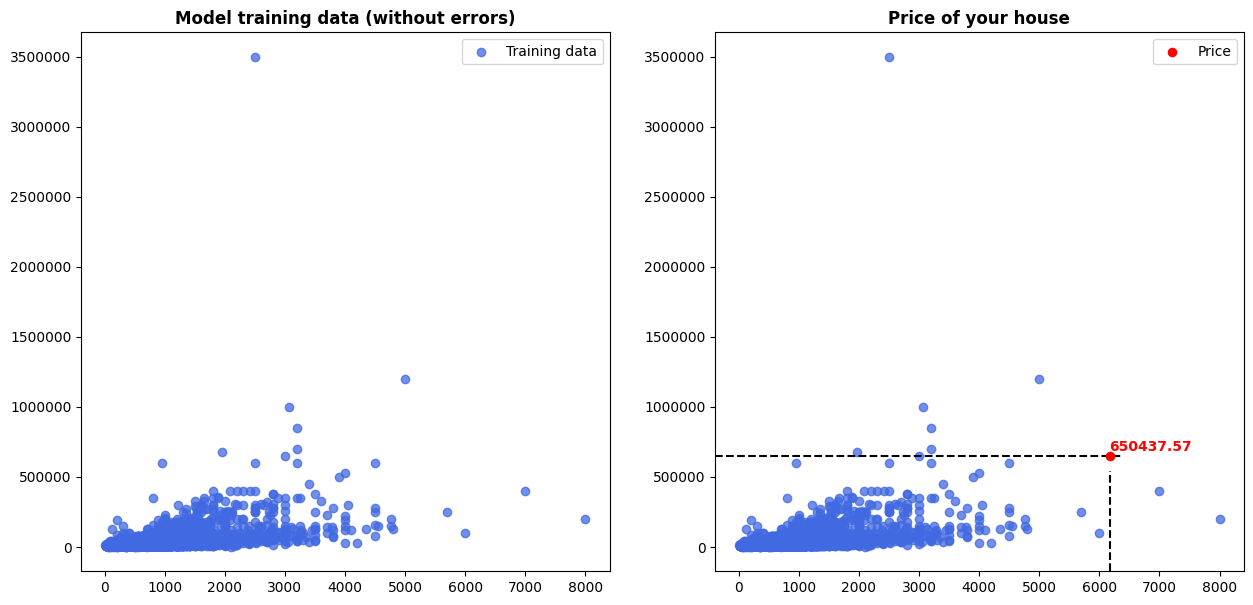

In [70]:
#Predicting price
price_prediction = model.predict(np.array(values).reshape(-1, len(values)))

#Printing results
labels = ['Training data', 'Price']
title = ['Model training data (without errors)', f'Price of your house']
line_bounds = [list(new_file_copy['Size']), price_arr]
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax = ax.flatten()
for i in range(len(ax)):
    if i != 0:
        ax[i].scatter(values[1]*max(list(df['Size'])), price_prediction[0], c='red', s=35, label=labels[i], zorder=5)
        ax[i].axhline(y=price_prediction[0], xmin=0, xmax=values[1]*max(list(df['Size']))/max(list(new_file_copy['Size'])) , linestyle='dashed', linewidth=1.5, c='k')
        ax[i].axvline(x=values[1]*max(list(df['Size'])), ymin=0, ymax=price_prediction[0]/max(list(price_arr)), linestyle='dashed', linewidth=1.5, c='k')
        ax[i].scatter(new_file_copy['Size'], price_arr, c='royalblue', alpha=0.75)
        ax[i].text(values[1]*max(list(df['Size'])), price_prediction[0] + np.array(price_arr).mean(), f"{price_prediction[0]:.2f}", c='r', weight='bold')
    else:
        ax[i].scatter(new_file_copy['Size'], price_arr, c='royalblue', alpha=0.75, label=labels[i])
    ax[i].ticklabel_format(axis='y', style='plain')
    ax[i].legend(loc=1)
    ax[i].set_title(f"{title[i]}", weight='bold')
plt.show()